Only differences between this notebook an `1task-concept.ipynb` will be commented here. See `1task-concept.ipynb` for more thorough explanations.

# General setup

In [60]:
import os, sys, subprocess
import time
from glob import glob
import itertools
from functools import partial
import copy
import gc

import importlib
sys.path.insert(1, os.path.realpath('lib'))
if "utils" not in sys.modules: import utils
else: importlib.reload(utils)
if "ml" not in sys.modules: import ml
else: importlib.reload(ml)
if "train" not in sys.modules: import train
else: importlib.reload(train)

# >>>
import ipynbname
nb_base = ipynbname.name().split('_')[0]
# <<<

import numpy as np

# >>>
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import h5py
# <<<

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
if not utils.is_notebook():
    import torch.multiprocessing as mp

In [61]:
# >>>
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# <<<

Using cuda device


# Loading Data

In [17]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

raw_train_dataset = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

raw_test_dataset = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

Shape of X [N, C, H, W]:  torch.Size([16, 1, 28, 28])
Shape of y:  torch.Size([16]) torch.int64
Shape of z:  torch.Size([16]) torch.int64


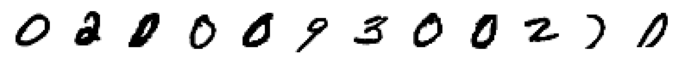

tensor([0, 2, 0, 0, 0, 9, 3, 0, 0, 2, 7, 0])
tensor([ 7, 11, 17, 15,  0,  3,  2,  7,  5, 15,  2,  3])


In [18]:
# >>>
preview_dataloader = DataLoader(
    ml.RelabeledSubset(raw_train_dataset, class_size=100,
                       target2_config=20, transform=transform),
    batch_size=16, shuffle=True)

X, y, z = next(iter(preview_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)
print("Shape of z: ", z.shape, z.dtype)
    
utils.plot_images(X.clamp_(-1, 1), num=12)
print(y[:12])
print(z[:12])
# <<<

# Training

In [23]:
HIDDEN_SIZE = 100
CLASS_SIZE = 100
BATCH_SIZE = 50
NUM_SETS = 10

DECORR_STRENGTH = 0.5
NUM_REPLICATES = 16
decorr_criteria = itertools.chain.from_iterable((
    itertools.repeat(None, NUM_REPLICATES),
    itertools.repeat(ml.decorr_criterion, NUM_REPLICATES),
    itertools.repeat(ml.halfcorr_criterion, NUM_REPLICATES)
))

# Evaluate digit classification performance with held-out test data and save test
# activations and outputs.
MODE = ['testval', 'testsave']

train_dataset = (
    ml.RelabeledSubset,
    dict(dataset=raw_train_dataset, class_size=CLASS_SIZE,
         target2_config=NUM_SETS, transform=transform)
)
test_dataset = (
    ml.RelabeledSubset,
    dict(dataset=raw_test_dataset,
         target2_config='none', transform=transform)
)

model = (
    ml.TwoTargetMLP,
    dict(hidden_size=HIDDEN_SIZE,
         target1_size=10, target2_size=NUM_SETS,
         nonlinearity1=nn.Tanh(), nonlinearity2=nn.Tanh())
)

devices = itertools.cycle([torch.device('cuda', i)
                           for i in range(torch.cuda.device_count())])

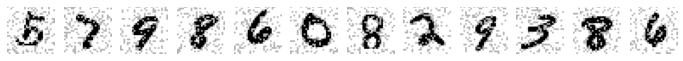

In [24]:
NUM_EPOCHS = 100
PRINT_EPOCHS = NUM_EPOCHS
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0

def NOISE_FN(data):
    mask = torch.rand_like(data)
    threshold = mask.quantile(0.2)
    mask = (mask - threshold > 0).float()
    noisy_data = data * mask
    return noisy_data

# >>>
X, _, _ = next(iter(preview_dataloader))
noisy_X = NOISE_FN(X)
utils.plot_images(noisy_X.clamp_(-1., 1.), num=12)
# <<<

In [25]:
kwargs_map = [dict(device=dev, decorr_criterion=param)
               for dev, param
               in zip(devices, decorr_criteria)]
kwargs_partial = dict(model=model,
                      mode=MODE,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      decorr_strength=DECORR_STRENGTH,
                      noise_fn=NOISE_FN,
                      batch_size=BATCH_SIZE,
                      learning_rate=LEARNING_RATE,
                      num_epochs=NUM_EPOCHS,
                      print_epochs=PRINT_EPOCHS)
# >>>
print(kwargs_map[0])
print(len(list(kwargs_map)))
# <<<

{'device': device(type='cuda', index=0), 'decorr_criterion': None}
48


In [26]:
# >>>
i_train = 2*NUM_REPLICATES
print(model)
utils.start_timer()
result = train.two_target_train(
    **(kwargs_partial | {'print_epochs': 5}),
    **kwargs_map[i_train]
)
utils.end_timer_and_print()
# <<<

(<class 'ml.TwoTargetMLP'>, {'hidden_size': 100, 'target1_size': 10, 'target2_size': 10, 'nonlinearity1': Tanh(), 'nonlinearity2': Tanh()})
cuda:0   0)   loss:  2.175  2.327  3.684e+00   train: 0.298 0.108   test: 0.536 0.117
cuda:0   4)   loss:  0.794  2.246  1.772e+00   train: 0.862 0.180   test: 0.828 0.181
cuda:0   9)   loss:  0.377  2.155  1.486e+00   train: 0.932 0.242   test: 0.862 0.231
cuda:0  14)   loss:  0.230  2.057  1.260e+00   train: 0.969 0.296   test: 0.875 0.269
cuda:0  19)   loss:  0.154  1.920  1.223e+00   train: 0.986 0.377   test: 0.876 0.322
cuda:0  24)   loss:  0.113  1.726  1.165e+00   train: 0.993 0.476   test: 0.874 0.408
cuda:0  29)   loss:  0.087  1.470  1.159e+00   train: 0.999 0.612   test: 0.870 0.486
cuda:0  34)   loss:  0.074  1.182  1.097e+00   train: 1.000 0.723   test: 0.867 0.571
cuda:0  39)   loss:  0.067  0.865  1.114e+00   train: 1.000 0.841   test: 0.868 0.627
cuda:0  44)   loss:  0.059  0.598  1.102e+00   train: 1.000 0.917   test: 0.864 0.701


In [29]:
if not utils.is_notebook():
    train_partial = partial(train.two_target_train, **kwargs_partial)
   
    MAX_PROCESSES = 2 * torch.cuda.device_count()
    
    if __name__ == "__main__":
        utils.start_timer()
        mp.set_start_method('spawn', force=True)
        
        num_processes = min(len(kwargs_map), MAX_PROCESSES)
        with mp.Pool(num_processes) as p:
            results = utils.kwstarmap(p, train_partial, kwargs_map)

        utils.end_timer_and_print()

In [30]:
# >>$
subprocess.call(["/bin/bash", "-c",
                 f"$(pwd)/converted/nb2script.sh {nb_base}.ipynb"])

[NbConvertApp] Converting notebook 2tasks.ipynb to script
[NbConvertApp] Writing 10747 bytes to converted/2tasks.py


0

In [31]:
nb_script = f"converted/{nb_base}.py"
%run -i $nb_script

cuda:6   0)   loss:  2.152  2.308  7.390e+00   train: 0.374 0.106   test: 0.622 0.134
cuda:6  99)   loss:  0.014  0.029  3.125e+00   train: 1.000 1.000   test: 0.868 0.776
cuda:3   0)   loss:  2.159  2.319  4.365e+00   train: 0.290 0.100   test: 0.535 0.129
cuda:3  99)   loss:  0.027  0.040  9.099e-01   train: 1.000 1.000   test: 0.849 0.824
cuda:6   0)   loss:  2.162  2.310  7.623e+00   train: 0.319 0.092   test: 0.620 0.125
cuda:6  99)   loss:  0.015  0.031  3.050e+00   train: 1.000 1.000   test: 0.864 0.767
cuda:6   0)   loss:  2.189  2.311  3.426e+00   train: 0.261 0.103   test: 0.493 0.134
cuda:6  99)   loss:  0.025  0.040  9.144e-01   train: 1.000 1.000   test: 0.856 0.793
cuda:2   0)   loss:  2.159  2.323  5.065e+00   train: 0.298 0.102   test: 0.558 0.119
cuda:2  99)   loss:  0.018  0.044  9.722e-01   train: 1.000 1.000   test: 0.875 0.856
cuda:4   0)   loss:  2.106  2.315  5.970e+00   train: 0.398 0.109   test: 0.633 0.122
cuda:4  99)   loss:  0.015  0.029  3.206e+00   train: 

# Accuracy

In [79]:
losses = np.array([result[0] for result in results])
train_accuracies = np.array([result[1] for result in results])
test_accuracies = np.array([result[2] for result in results])
y_activations = np.array([result[3][0] for result in results])
z_activations = np.array([result[3][1] for result in results])
y_weights = np.array([result[4][0] for result in results])
z_weights = np.array([result[4][1] for result in results])
y_biases = np.array([result[5][0] for result in results])
z_biases = np.array([result[5][1] for result in results])
class_targets = np.array([result[6][0] for result in results])
set_targets = np.array([result[6][1] for result in results])

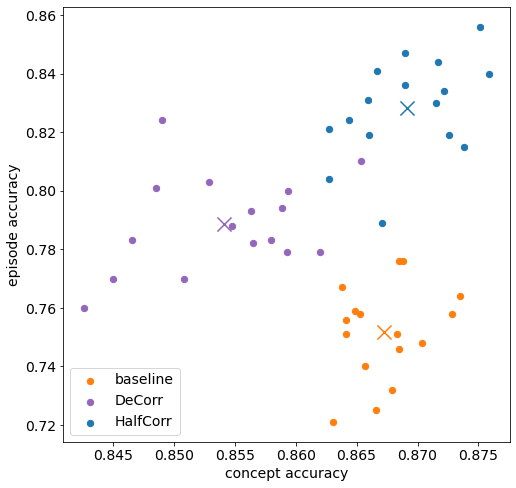

4.236612770262297e-08
0.16681370962415767
1.293784260584245e-08
4.594287906734713e-07
7.146803536269428e-14
2.1346290120781238e-07


In [80]:
class_accuracies = test_accuracies[:,-1,0].reshape(-1, NUM_REPLICATES)
set_accuracies = test_accuracies[:,-1,1].reshape(-1, NUM_REPLICATES)

mean_class_accs = class_accuracies.mean(-1)
mean_set_accs = set_accuracies.mean(-1)

fig, ax = plt.subplots(figsize=(8, 8))
labels = ('baseline', 'DeCorr', 'HalfCorr')
colors = ('tab:orange', 'tab:purple', 'tab:blue')
# individual values as points
for accs1, accs2, color, label \
in zip(class_accuracies, set_accuracies, colors, labels):
    ax.scatter(accs1, accs2, s=40, color=color, label=label)
# means as x's
for accs1, accs2, color, label \
in zip(mean_class_accs, mean_set_accs, colors, labels):
    ax.scatter(accs1, accs2, s=200, marker="x", color=color)
ax.set_xlabel("concept accuracy")
ax.set_ylabel("episode accuracy")
ax.legend(loc="lower left")
plt.show()
    
print(stats.ttest_ind(class_accuracies[0], class_accuracies[1]).pvalue)
print(stats.ttest_ind(class_accuracies[0], class_accuracies[2]).pvalue)
print(stats.ttest_ind(class_accuracies[1], class_accuracies[2]).pvalue)
print(stats.ttest_ind(set_accuracies[0], set_accuracies[1]).pvalue)
print(stats.ttest_ind(set_accuracies[0], set_accuracies[2]).pvalue)
print(stats.ttest_ind(set_accuracies[1], set_accuracies[2]).pvalue)

# Influence

In [81]:
# Index limits for HalfCorr simulations
start = 2 * NUM_REPLICATES
stop = None

# Taking only HalfCorr simulations
y_activations = y_activations[start:stop]
z_activations = z_activations[start:stop]
y_weights = y_weights[start:stop]
z_weights = z_weights[start:stop]
y_biases = y_biases[start:stop]
z_biases = z_biases[start:stop]
class_targets = class_targets[start:stop]
set_targets = set_targets[start:stop]

In [82]:
# Calculating mean variance in neural activation within the same digit class
inds_by_class = [[np.where(targets == target)[0]
                  for target in np.unique(targets)]
                 for targets in class_targets]
variances = np.array([np.array([activations[inds].var(0)
                       for inds in inds_by_class]).mean(0)
                     for activations, inds_by_class
                     in zip(y_activations, inds_by_class)]).mean(0)

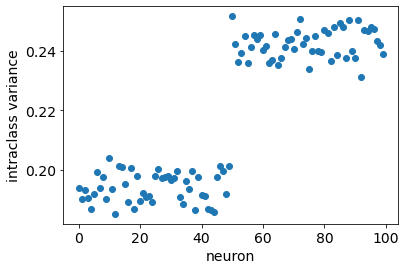

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(range(HIDDEN_SIZE), variances, color='tab:blue')
ax.set_xlabel("neuron")
ax.set_ylabel("intraclass variance")
plt.show()

In [84]:
# Computing logits used for concept and example predictions
y_logits_by_neuron = (np.expand_dims(y_activations.transpose(0,2,1), 3)
                      * np.expand_dims(y_weights.transpose(0,2,1), 2))
z_logits_by_neuron = (np.expand_dims(z_activations.transpose(0,2,1), 3)
                      * np.expand_dims(z_weights.transpose(0,2,1), 2))

y_logits = np.expand_dims(y_logits_by_neuron.sum(1)
                          + np.expand_dims(y_biases, 1), 1)
z_logits = np.expand_dims(z_logits_by_neuron.sum(1)
                          + np.expand_dims(z_biases, 1), 1)

# Compute effect of silencing each neuron
y_logits_without_neuron = y_logits - y_logits_by_neuron
z_logits_without_neuron = z_logits - z_logits_by_neuron

In [85]:
# Computing accuracies from logits
class_accuracies = np.mean(y_logits.argmax(3)
                           == np.expand_dims(class_targets, 1), (0,2))
set_accuracies = np.mean(z_logits.argmax(3)
                         == np.expand_dims(set_targets, 1), (0,2))

class_acc_without_neuron = np.mean(y_logits_without_neuron.argmax(3)
                                   == np.expand_dims(class_targets, 1), (0,2))
set_acc_without_neuron = np.mean(z_logits_without_neuron.argmax(3)
                                 == np.expand_dims(set_targets, 1), (0,2))

# Influence is the mean decrease in accuracy upon silencing neuron
class_influences = class_accuracies - class_acc_without_neuron
set_influences = set_accuracies - set_acc_without_neuron

In [86]:
if "h5file" in globals():
    h5file.close()
h5file = h5py.File(f"out/{nb_base}.h5", 'w')

h5file.create_dataset("losses", data=losses)
h5file.create_dataset("test_accuracies", data=test_accuracies)
h5file.create_dataset("variances", data=variances)
h5file.create_dataset("class_influences", data=class_influences)
h5file.create_dataset("set_influences", data=set_influences)

h5file.close()

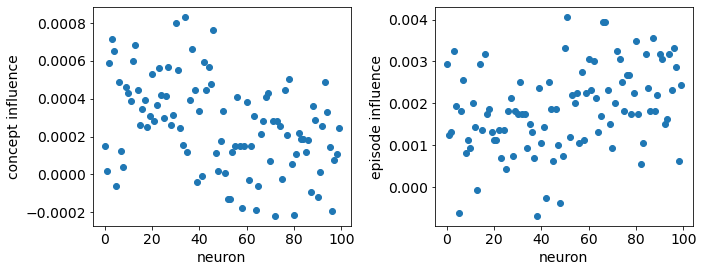

0.000378624999999988 0.00014624999999998333 3.9625259831892285e-07
0.0014025000000000066 0.0023249999999999994 1.2441994283013196e-06


In [88]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(range(HIDDEN_SIZE), class_influences, color='tab:blue')
axes[0].set_xlabel("neuron")
axes[0].set_ylabel("concept influence")
axes[1].scatter(range(HIDDEN_SIZE), set_influences, color='tab:blue')
axes[1].set_xlabel("neuron")
axes[1].set_ylabel("episode influence")
fig.tight_layout()
plt.show()

# Comparing influences between first and second halves of the hidden layer
half = int(round(HIDDEN_SIZE/2))
class_influences0 = class_influences[:half]
class_influences1 = class_influences[half:]
set_influences0 = set_influences[:half]
set_influences1 = set_influences[half:]
print(class_influences0.mean(), class_influences1.mean(),
      stats.ttest_ind(class_influences0, class_influences1).pvalue)
print(set_influences0.mean(), set_influences1.mean(),
      stats.ttest_ind(set_influences0, set_influences1).pvalue)